In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('tensorflow version : ', tf.__version__)
print('keras version : ', keras.__version__)

matplotlib version : 3.1.3
scipy version : 1.4.1
numpy version : 1.18.1
tensorflow version :  2.2.0
keras version :  2.3.0-tf


In [15]:
df = pd.read_csv('nikkei225.csv')

In [17]:
df = df.drop(range(0,7893))
df = df.drop('index', axis=1)
df = df.reset_index()

In [25]:
df.head()

,date,value
0,1981-01-06,7137.59
1,1981-01-07,7200.77
2,1981-01-08,7222.14
3,1981-01-09,7248.13
4,1981-01-12,7251.88


In [26]:
df.tail()

,date,value
9991,2021-04-27,28991.89
9992,2021-04-28,29053.97
9993,2021-04-30,28812.63
9994,2021-05-06,29331.37
9995,2021-05-07,29357.82


In [27]:
df.columns

Index(['date', 'value'], dtype='object')

In [28]:
def shape_data(data_list):
  return [d / data_list[0] - 1 for d in data_list]

df['data_list'] = shape_data(df['value'])

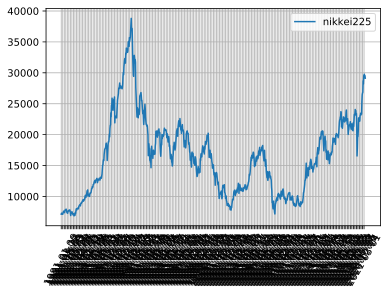

In [29]:
ticks = 10
xticks = ticks * 5 

plt.plot(df['date'][::ticks], df['value'][::ticks], label='nikkei225')
plt.grid()
plt.legend()
plt.xticks(df['date'][::xticks], rotation=60)
plt.show()

C:\Users\choadmin\anaconda3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\choadmin\anaconda3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\choadmin\anaconda3\lib\site-packages\matplotlib\textpath.py:203: RuntimeWarning: Glyph 65288 missing from current font.
  glyph = font.load_char(ccode, flags=LOAD_NO_HINTING)
C:\Users\choadmin\anaconda3\lib\site-packages\matplotlib\textpath.py:203: RuntimeWarning: Glyph 65289 missing from current font.
  glyph = font.load_char(ccode, flags=LOAD_NO_HINTING)


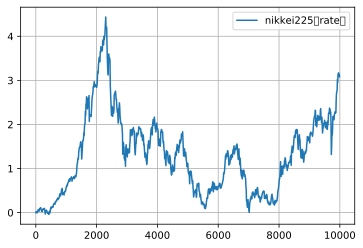

In [30]:
plt.plot(df.index.values[::ticks], df['data_list'][::ticks], label='nikkei225（rate）')
plt.grid()
plt.legend()
plt.show()

In [31]:
# 予測に利用するデータ数
# 90個のデータから後の30個のデータを予測する
NUM_LSTM = 9648

# 中間層の数
NUM_MIDDLE = 200

# ニューラルネットのモデルの定数
batch_size = 100
epochs = 2000
validation_split = 0.25

In [32]:
def get_x_y_lx_ly(term_part):
  
  date = np.array(df['date'][0:9995])
  x = np.array(df.index.values[0:9995])
  y = np.array(df['data_list'][0:9995])
  
  n = len(y) - NUM_LSTM
  l_x = np.zeros((n, NUM_LSTM))
  l_y = np.zeros((n, NUM_LSTM))
  
  for i in range(0, n):
    l_x[i] = y[i: i + NUM_LSTM]
    l_y[i] = y[i + 1: i + NUM_LSTM + 1]
  
  l_x = l_x.reshape(n, NUM_LSTM, 1)
  l_y = l_y.reshape(n, NUM_LSTM, 1)
  
  return n, date, x, y, l_x, l_y

n, date, x, y, l_x, l_y = get_x_y_lx_ly(0)

In [33]:
print('shape : ', x.shape)
print('ndim : ', x.ndim)
print('data : ', x[:10])

shape :  (9995,)
ndim :  1
data :  [0 1 2 3 4 5 6 7 8 9]


In [34]:
print('shape : ', y.shape)
print('ndim : ', y.ndim)
print('data : ', y[:10])

shape :  (9995,)
ndim :  1
data :  [0.         0.00885173 0.01184574 0.01548702 0.01601241 0.01530068
 0.01501767 0.01501767 0.01656862 0.02220497]


In [35]:
print(l_y.shape)
print(l_x.shape)

(347, 9648, 1)
(347, 9648, 1)


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU


def build_model(model_name='RNN'):
  # LSTMニューラルネットの構築
  model = Sequential()
  
  # RNN,LSTM、GRUを選択できるようにする
  if model_name == 'RNN':
    model.add(SimpleRNN(NUM_MIDDLE, input_shape=(NUM_LSTM, 1), return_sequences=True))
  
  if model_name == 'LSTM':
    model.add(LSTM(NUM_MIDDLE, input_shape=(NUM_LSTM, 1), return_sequences=True))
  
  if model_name == 'GRU':
    model.add(GRU(NUM_MIDDLE, input_shape=(NUM_LSTM, 1), return_sequences=True))
  
  model.add(Dense(1, activation="linear"))
  model.compile(loss="mean_squared_error", optimizer="sgd")
  
  return model


# ニューラルネットを深くした（今回は使わない）
def build_model_02(): 
  
  NUM_MIDDLE_01 = 100
  NUM_MIDDLE_02 = 120
  
  # LSTMニューラルネットの構築
  model = Sequential()
  model.add(LSTM(NUM_MIDDLE_01, input_shape = (NUM_LSTM, 1), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(NUM_MIDDLE_02, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.add(Activation("linear"))
  model.compile(loss="mean_squared_error", optimizer="sgd")
  # model.compile(loss="mse", optimizer='rmsprop')
    
  return model
  
model = build_model('RNN')

In [37]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 9648, 200)         40400     
_________________________________________________________________
dense (Dense)                (None, 9648, 1)           201       
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# validation_split で最後の10％を検証用に利用します
history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)